# 定义网络

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # N = (W - F + 2P) / S + 1
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # [32, 26, 26]
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # [64, 24, 24]
        # max_pool2d [64, 12, 12]
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # [128]
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # [10]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = self.dropout1(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# 加载训练好的模型

In [2]:
checkpoint = '../../checkpoints/mnist.pt' # 训练完成的权重文件的路径
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load(checkpoint))
model = model.to(device)
model.eval() # 将模型设为eval模式

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# 加载图像并预测

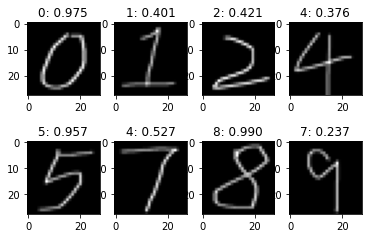

In [3]:
import math
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torchvision import transforms

data_dir = 'data' # 存放预测图像的文件夹路径
paths = list(Path(data_dir).iterdir())
total = len(paths)
col = 4
row = math.ceil(total / col)

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
with torch.no_grad():
    for i, path in enumerate(paths, start=1):
        plt.subplot(row, col, i)
        img_path = str(path)
        img = Image.open(img_path).convert('L')
        img = img.point(lambda p: p < 128 and 255) # 二值化图像，小于128的像素值设为255，否则0
        tensor = transform(img) # 将图像缩放至28*28，并将值压缩至 [0, 1.0]
        tensor = tensor.unsqueeze(0).to(device)
        output = model(tensor)
        preds = F.softmax(output, 1) # 将结果压缩至 [0,1.0]
        v, idx = preds.topk(1) # 获取topk的结果
        img = img.resize((28,28))
        plt.imshow(img, cmap='gray')
        plt.title('{}: {:.3f}'.format(idx.item(), v.item()))
plt.show()